In [11]:
from typing import List, Tuple
import numpy as np


class Worldstate:
  def __init__(self, seed: int, terrain_size: int, wall_height: float, noise_resolution: float, avatar_width: float) -> None:
    self.seed = seed
    self.terrain_size = terrain_size
    self.wall_height = wall_height
    self.avatar_width = avatar_width

    rng = np.random.Generator(np.random.PCG64(seed))
    self.terrain = sample_2d_perlin_noise_region(
      rng,
      np.zeros(2),
      np.full(2, terrain_size - 1),
      (terrain_size, terrain_size),
      noise_resolution
    )
    self.position = np.full(2, terrain_size / 2) + rng.random(2) - 0.5

  @staticmethod
  def random(
    terrain_size: int = 256,
    wall_height: float = 0.52,
    noise_resolution: float = 15,
    avatar_width: float = 0.5,
    avoid_wall_start: bool = True
  ) -> 'Worldstate':
    state = Worldstate(np.random.randint(0, 2**31), terrain_size, wall_height, noise_resolution, avatar_width)
    r = avatar_width / 2
    while avoid_wall_start and any([state.terrain[int((state.position[1] + yo).round()), int((state.position[0] + xo).round())] >= wall_height for xo, yo in [[0, 0], [r, r], [r, -r], [-r, r], [-r, r]]]):
      state = Worldstate(np.random.randint(0, 2**31), terrain_size, wall_height, noise_resolution, avatar_width)
    return state

  def act(self, action: np.ndarray):
    r = self.avatar_width / 2
    corners = self.position[None, :] + np.array([[0, 0], [r, r], [r, -r], [-r, r], [-r, r]])
    action_progression = np.stack([self._cast_ray(ray_origin=corner, action=action) for corner in corners]).min(0)
    self.position += action_progression * action

  def _cast_ray(self, ray_origin: np.ndarray, action: np.ndarray) -> np.ndarray:
    first_edges = np.ceil(ray_origin - 0.5) * (action >= 0) + np.floor(ray_origin - 0.5) * (action < 0) + 0.5  # edges are on 0.5 grid offset instead of integers
    check_blocks_for_collision = []
    for axis, counteraxis in [(0, 1), (1, 0)]:
      for edge in np.arange(first_edges[axis], first_edges[axis] + action[axis], 1 if action[axis] >= 0 else -1):
        action_progression = (edge - first_edges[axis]) / action[axis]
        counter_collision_pos = int(np.round(action_progression * action[counteraxis] + ray_origin[counteraxis]).item())
        axial_collision_pos = int((np.ceil(edge) if action[axis] >= 0 else np.floor(edge)).item())
        block_coordinates = np.zeros(2, dtype=np.int32)
        block_coordinates[axis] = axial_collision_pos
        block_coordinates[counteraxis] = counter_collision_pos
        check_blocks_for_collision.append((action_progression, axis, block_coordinates))
    check_blocks_for_collision = sorted(check_blocks_for_collision, key=lambda c: c[0])

    starting_block = ray_origin.round().astype(np.int32)
    altitude = self.terrain[starting_block[1], starting_block[0]]
    action_progressions = np.zeros(2)
    collision = np.zeros(2, dtype=np.bool)
    for action_progression, axis, block_coordinates in check_blocks_for_collision:
      next_altitude = self.terrain[block_coordinates[1], block_coordinates[0]]
      if next_altitude >= altitude and next_altitude >= self.wall_height:
        collision[axis] = True
      if not collision[axis]:
         action_progressions[axis] = action_progression
      altitude = next_altitude
    action_progressions[~collision] = 1
    return action_progressions

  def render(self, camera_size: int) -> np.ndarray:
    corner1 = self.position - camera_size / 2
    floor_corner1 = np.floor(corner1).astype(np.int32)
    x_offset, y_offset = corner1 - floor_corner1

    xc, yc = floor_corner1
    tl = padded_slice(self.terrain, [slice(yc, yc + camera_size), slice(xc, xc + camera_size)])
    tr = padded_slice(self.terrain, [slice(yc, yc + camera_size), slice(xc + 1, xc + camera_size + 1)])
    bl = padded_slice(self.terrain, [slice(yc + 1, yc + camera_size + 1), slice(xc, xc + camera_size)])
    br = padded_slice(self.terrain, [slice(yc + 1, yc + camera_size + 1), slice(xc + 1, xc + camera_size + 1)])
    tl, tr, bl, br = [self._augment_altitude_render(region) for region in [tl, tr, bl, br]]
    antialiased = (
      tl * (1 - x_offset) * (1 - y_offset)
      + tr * x_offset * (1 - y_offset)
      + bl * (1 - x_offset) * y_offset
      + br * x_offset * y_offset
    )
    centerpoint_mask = np.zeros_like(antialiased[:, :, 0], dtype=np.bool)
    centerpoint_mask[camera_size // 2, camera_size // 2] = True
    return np.stack((antialiased[:, :, 0] * ~centerpoint_mask, antialiased[:, :, 1], antialiased[:, :, 2] * ~centerpoint_mask), axis=2)
  
  def _augment_altitude_render(self, region) -> np.ndarray:
     return np.stack((region, region * (region < self.wall_height), region * (region < self.wall_height)), axis=2)

def sample_2d_perlin_noise_region(rng: np.random.Generator, corner1: np.ndarray, corner2: np.ndarray, pixel_resolution: Tuple[int, int], noise_resolution: float) -> np.ndarray:
    fade = lambda t: t * t * t * (t * (t * 6 - 15) + 10)
    lerp = lambda a, b, t: a + t * (b - a)
    def gradient(h, x, y):
        g = h & 3
        return np.where(g < 2, x, -x) + np.where(g & 1 == 0, y, -y)
    
    x_coords = np.linspace(corner1[0], corner2[0], pixel_resolution[0])
    y_coords = np.linspace(corner1[1], corner2[1], pixel_resolution[1])
    X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
    X_grid, Y_grid = X / noise_resolution, Y / noise_resolution
    X0, Y0 = np.floor(X_grid).astype(int), np.floor(Y_grid).astype(int)
    X1, Y1 = X0 + 1, Y0 + 1
    fx, fy = X_grid - X0, Y_grid - Y0
    u, v = fade(fx), fade(fy)
    
    # rng = np.random.Generator(np.random.PCG64(global_seed))
    p = np.arange(512, dtype=int)
    rng.shuffle(p[:256])
    p[256:] = p[:256]
    hash_coord = lambda x, y: p[p[x & 255] + (y & 255)]
    
    h00, h10, h01, h11 = hash_coord(X0, Y0), hash_coord(X1, Y0), hash_coord(X0, Y1), hash_coord(X1, Y1)
    g00, g10, g01, g11 = gradient(h00, fx, fy), gradient(h10, fx - 1, fy), gradient(h01, fx, fy - 1), gradient(h11, fx - 1, fy - 1)
    result = lerp(lerp(g00, g10, u), lerp(g01, g11, u), v)
    
    return np.clip((result + 1) / 2, 0, 1)

# def fill_crop(img, pos, crop):
#   """
#   Fills `crop` with values from `img` at `pos`, 
#   while accounting for the crop being off the edge of `img`.
#   *Note:* negative values in `pos` are interpreted as-is, not as "from the end".

#   Taken from https://stackoverflow.com/questions/41153803/zero-padding-slice-past-end-of-array-in-numpy
#   """
#   img_shape, pos, crop_shape = np.array(img.shape), np.array(pos), np.array(crop.shape),
#   end = pos+crop_shape
#   # Calculate crop slice positions
#   crop_low = np.clip(0 - pos, a_min=0, a_max=crop_shape)
#   crop_high = crop_shape - np.clip(end-img_shape, a_min=0, a_max=crop_shape)
#   crop_slices = (slice(low, high) for low, high in zip(crop_low, crop_high))
#   # Calculate img slice positions
#   pos = np.clip(pos, a_min=0, a_max=img_shape)
#   end = np.clip(end, a_min=0, a_max=img_shape)
#   img_slices = (slice(low, high) for low, high in zip(pos, end))
#   crop[tuple(crop_slices)] = img[tuple(img_slices)]

def padded_slice(array: np.ndarray, slices: List[slice], pad_value: float = 0) -> np.ndarray:
    """
    Extract a region from a 2D array with padding for out-of-bounds indices.
    
    Parameters:
    -----------
    array : np.ndarray
        Input 2D array
    slices : List[slice]
        List of slice objects defining the region to extract
    pad_value : float
        Value to use for padding out-of-bounds regions (default: 0)
    
    Returns:
    --------
    np.ndarray
        Extracted region with padding where needed
    
    Examples:
    ---------
    >>> arr = np.arange(9).reshape(3, 3)
    >>> padded_slice(arr, [slice(-1, 2), slice(-1, 2)])
    array([[0., 0., 0.],
           [0., 0., 1.],
           [0., 3., 4.]])
    """
    # Calculate output shape from slices
    out_shape = []
    for s in slices:
        start = s.start if s.start is not None else 0
        stop = s.stop if s.stop is not None else array.shape[len(out_shape)]
        step = s.step if s.step is not None else 1
        out_shape.append((stop - start + step - 1) // step)
    
    # Create output array filled with pad_value
    out = np.full(out_shape, pad_value, dtype=array.dtype)
    
    # Calculate the valid region in both input and output arrays
    src_slices = []
    dst_slices = []
    
    for i, s in enumerate(slices):
        start = s.start if s.start is not None else 0
        stop = s.stop if s.stop is not None else array.shape[i]
        step = s.step if s.step is not None else 1
        
        # Clamp source indices to array bounds
        src_start = max(0, start)
        src_stop = min(array.shape[i], stop)
        
        # Calculate corresponding destination indices
        dst_start = (src_start - start + step - 1) // step if step > 0 else 0
        dst_stop = dst_start + ((src_stop - src_start + step - 1) // step)
        
        src_slices.append(slice(src_start, src_stop, step))
        dst_slices.append(slice(dst_start, dst_stop))
    
    # Copy valid region
    out[tuple(dst_slices)] = array[tuple(src_slices)]
    
    return out

In [19]:
padded_slice(np.arange(10)[:, None], [slice(6, 12), slice(0, 1)])

slice(6, 12, None)
slice(0, 1, None)


array([[6],
       [7],
       [8],
       [9],
       [0],
       [0]])

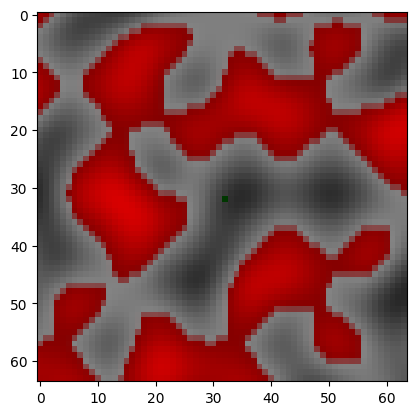

In [55]:
import matplotlib.pyplot as plt

state = Worldstate.random()
image = state.render(64)
plt.imshow(image)

In [10]:
# TEST OUT COLLISION

import cv2

state = Worldstate.random()
CAMERA_RESOLUTION = 64
UPSCALE_RESOLUTION = 512

def render():
  return cv2.resize(
    cv2.cvtColor(
      state.render(CAMERA_RESOLUTION).astype(np.float32),
      cv2.COLOR_RGB2BGR
    ),
    (UPSCALE_RESOLUTION, UPSCALE_RESOLUTION),
    interpolation=cv2.INTER_NEAREST
  )

def on_click(event, x, y, flags, param):
  if event != cv2.EVENT_LBUTTONDOWN:
    return
  click_position = np.array([x, y]) / UPSCALE_RESOLUTION
  displacement = (click_position - 0.5) * CAMERA_RESOLUTION
  state.act(displacement)
  cv2.imshow('worldstate', render())

cv2.imshow('worldstate', render())
cv2.setMouseCallback('worldstate', on_click)
cv2.waitKey(0)
cv2.destroyAllWindows()